In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
def resample(df, period):
    """Resample the frame df to period (in year)

    Input :
    -df : dataframe pandas with no index the time dimension exist as a year
        columns (column of integer)
    - period : integer : new wanted period

    Output : resampled frame
    """
    period = float(period)
    tuples = zip(df['code'],
                 (((df['year'].values) // period) * period) + period / 2.)
    df_copy = df.copy()
    df_copy.index = pd.MultiIndex.from_tuples(tuples)
    df_copy = df_copy.groupby(level=[0, 1]).mean().dropna(how='all')
    del df_copy['year']
    df_copy.index.names = ['code', 'year']
    return df_copy.sort_index()

In [4]:
def plot_correlations(data, min_match=20, size_tuple=(15,15)):
    """Plot the correlations between every variable of the data
    
    Input : pandas data frame with code, year as index and sorted
    in this order
    
    Output : graph of correlations
    """
    correlations = data.corr(min_periods=min_match)
    fig = plt.figure(figsize=size_tuple)
    norm = plt.cm.colors.Normalize(vmax=1, vmin=-1)
    plt.imshow(correlations, interpolation='nearest', norm=norm)
    plt.xticks(range(0, len(data.columns)), data.columns, rotation='vertical')
    plt.yticks(range(0, len(data.columns)), data.columns, rotation='horizontal')
    plt.colorbar()

In [5]:
variables = ["code", "year", "gini_DS", "GDP_PC_PWT", 
            "yrs_sec_schlg_M_25", "yrs_sec_schlg_F_25", "price_level_investment_PWT"]
data = pd.read_csv("../data_source/all_data.csv", usecols=variables)
data.loc[:, "log(GDP_PC_PWT)"] = data["GDP_PC_PWT"].apply(np.log)
del data["GDP_PC_PWT"]
growth = pd.read_csv("../data_source/all_data.csv", usecols=['year', 'code', 'GDP_growth_WB'])
re_growth = resample(growth, 5)
re_growth.reset_index(inplace=True)
re_growth.loc[:, "year"] -= 5
re_growth.set_index(['code', 'year'], inplace=True)
re_growth.columns = ["lagged_growth"]
re_data = resample(data, 5)
re_data = pd.merge(re_data, re_growth, how='outer', left_index=True, right_index=True)
re_data = re_data.dropna(how='any')
datafull_countries = re_data.groupby(level=0).size()[re_data.groupby(level=0).size() > 3].index.tolist()
re_data = re_data.query("code in " + str(datafull_countries))
print re_data.info()
re_data.reset_index(inplace=True)
re_data.set_index(['code', 'year'], inplace=True)
print "number of countries : ", len(set(re_data.index.levels[0]))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 205 entries, (AUS, 1967.5) to (VEN, 1992.5)
Data columns (total 6 columns):
gini_DS                       205 non-null float64
yrs_sec_schlg_F_25            205 non-null float64
yrs_sec_schlg_M_25            205 non-null float64
price_level_investment_PWT    205 non-null float64
log(GDP_PC_PWT)               205 non-null float64
lagged_growth                 205 non-null float64
dtypes: float64(6)
memory usage: 11.2+ KB
None
number of countries :  38


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


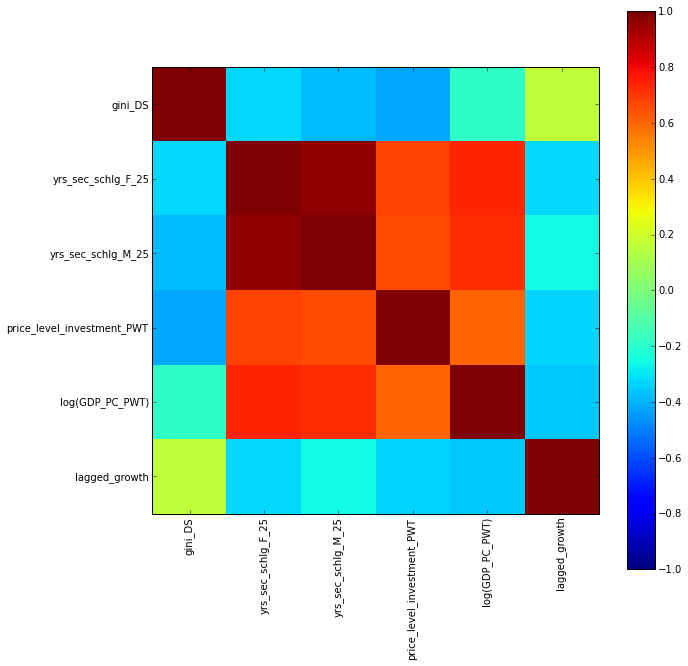

In [6]:
plot_correlations(re_data, size_tuple=(10,10))

Create dummy variables for country/period

In [7]:
for dummy in re_data.index.levels[0]:
    re_data[dummy] = (re_data.reset_index()['code'] == dummy).astype(int).values
for dummy in re_data.index.levels[1]:
    re_data[dummy] = (re_data.reset_index()['year'] == dummy).astype(int).values

# Regression part

In [8]:
X = re_data[np.delete(re_data.keys().values, 5)]
Y = re_data['lagged_growth']
X_sm = sm.add_constant(X)
model = sm.OLS(Y, X_sm)
all_results = model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:          lagged_growth   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     7.056
Date:                Thu, 03 Mar 2016   Prob (F-statistic):           3.79e-21
Time:                        14:21:14   Log-Likelihood:                -366.89
No. Observations:                 205   AIC:                             833.8
Df Residuals:                     155   BIC:                             999.9
Df Model:                          49                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
const                         37.0372      5.089      7.277      0.000        26.984    47.091
gini

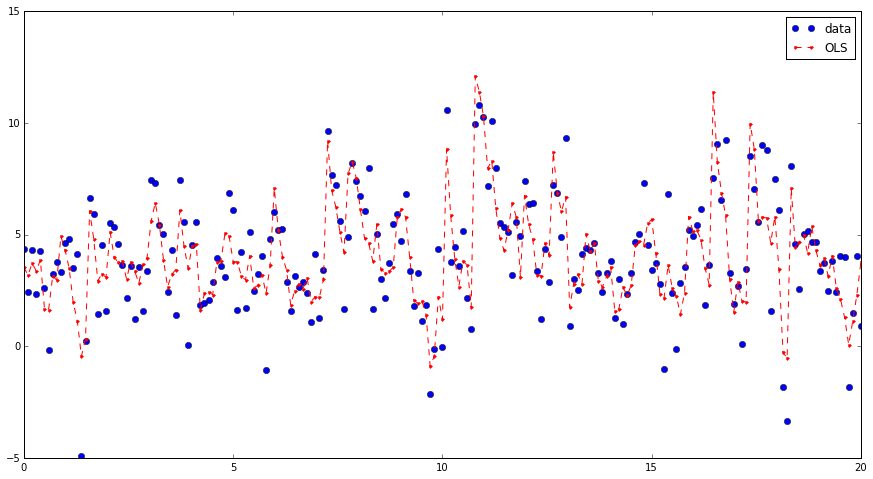

In [9]:
prstd, iv_l, iv_u = wls_prediction_std(all_results)
x = np.linspace(0, 20, len(X_sm))
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x, re_data['lagged_growth'], 'o', label="data")
ax.plot(x, all_results.fittedvalues, 'r--.', label="OLS")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

# Normalized regressions

In [10]:
X_norm = X.apply(lambda x: (x - x.mean()) / x.std())
Y_norm = (Y - Y.mean()) / Y.std()
X_sm = sm.add_constant(X_norm)
model_norm = sm.OLS(Y_norm, X_sm)
norm_results = model_norm.fit()
print(norm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          lagged_growth   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     7.056
Date:                Thu, 03 Mar 2016   Prob (F-statistic):           3.79e-21
Time:                        14:21:15   Log-Likelihood:                -170.18
No. Observations:                 205   AIC:                             440.4
Df Residuals:                     155   BIC:                             606.5
Df Model:                          49                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
const                      -4.231e-15      0.045  -9.49e-14      1.000        -0.088     0.088
gini

# Regression using only dummies

In [11]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=10**-50)
X_dum = re_data[np.delete(re_data.keys().values, range(6))]
clf.fit(X_dum, re_data['lagged_growth'])
print "score : ", (clf.score(X_dum, re_data['lagged_growth']))
print "Intercept : ", clf.intercept_
print "code   coeficient+intercept    average growth"
for i, variable in enumerate(X_dum.keys()):
    print variable, "   ",clf.coef_[i] + clf.intercept_, "      ", re_data.loc[variable, 'lagged_growth'].mean()

score :  0.543942708813
Intercept :  3.83982645547
code   coeficient+intercept    average growth
AUS     3.46321737532        3.53400855394
BGD     2.77246019633        3.16454329149
BGR     0.875794683523        0.746503918917
BRA     3.63403609162        4.02784724569
CAN     3.00756640592        3.70206349324
CHL     4.72550699882        5.0279289383
COL     3.24141072701        3.29583445418
CRI     4.2330084476        4.62681960167
DNK     2.30740579884        2.17811503423
DOM     4.51857045564        4.38927969104
ESP     3.0149778143        3.4169035026
FIN     2.91710348464        3.09782880637
FRA     3.06379685663        4.00395019997
GBR     2.15881356276        2.55089665792
HKG     6.31056180872        6.35320840448
IDN     5.74319399803        6.13527709319
IND     3.90660115182        4.60109823914
ITA     2.2435638226        2.28621041837
JAM     0.46074228901        0.515166016184
JPN     3.96191989109        4.35400298625
KOR     8.89963442405        9.3729968777
LKA

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:1323: FutureWarning: scalar indexers for index type MultiIndex should be integers and not floating point
  key = self._convert_scalar_indexer(key, axis)


TypeError: cannot do label indexing on <class 'pandas.core.index.MultiIndex'> with these indexers [1957.5] of <type 'numpy.float64'>

In [ ]:
x = np.linspace(0, 20, len(X_dum))
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x, re_data['lagged_growth'], 'o', label="data")
ax.plot(x, clf.predict(X_dum), 'r--.', label="OLS")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

# Now we fit the residus on the other variables

In [12]:
residus = re_data['lagged_growth'] - clf.predict(X_dum)
print "Growth standard deviation : ", re_data['lagged_growth'].std()
print "Residus standard deviation : ", residus.std()

 Growth standard deviation :  2.61057555322
Residus standard deviation :  1.7629742475


In [13]:
from sklearn import linear_model
X_var = re_data[np.delete(re_data.keys().values, range(5, len(re_data.keys())))]
clf_res = linear_model.Lasso(alpha=10**-50)
clf_res.fit(X_var, residus)
print "score : ", (clf_res.score(X_var, re_data['lagged_growth']))
print "Intercept : ", clf_res.intercept_
print "variable   coeficient"
for i, variable in enumerate(X_var.keys()):
    print variable, "   ",clf_res.coef_[i]
print "Residus standard deviation : ", residus.std()
print "Residus of residus standard deviation : ", (residus - clf_res.predict(X_var)).std()

score :  -2.37210764974
Intercept :  1.92481431869
variable   coeficient
gini_DS     1.24778528618
yrs_sec_schlg_F_25     -0.158780308098
yrs_sec_schlg_M_25     0.40862894061
price_level_investment_PWT     -0.00314200609777
log(GDP_PC_PWT)     -0.306830344618
Residus standard deviation :  1.7629742475
Residus of residus standard deviation :  1.7428194318


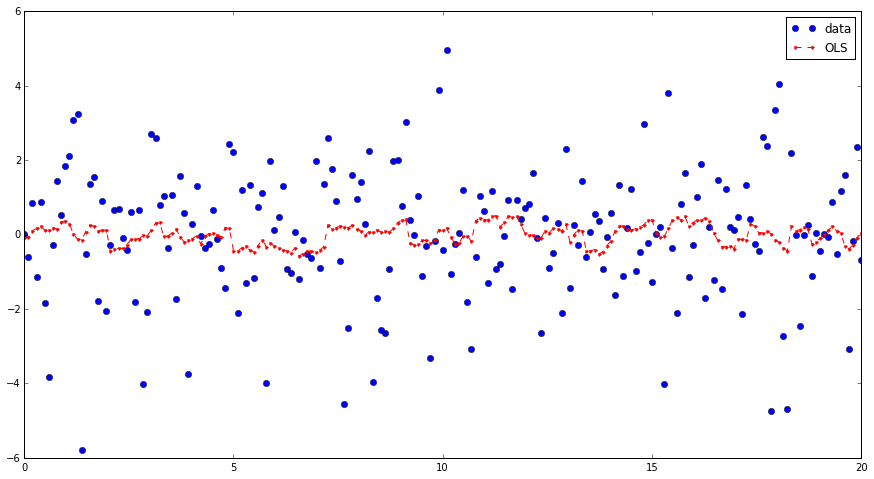

In [14]:
x = np.linspace(0, 20, len(X_var))
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x, residus, 'o', label="data")
ax.plot(x, clf_res.predict(X_var), 'r--.', label="OLS")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

# Scatter plots

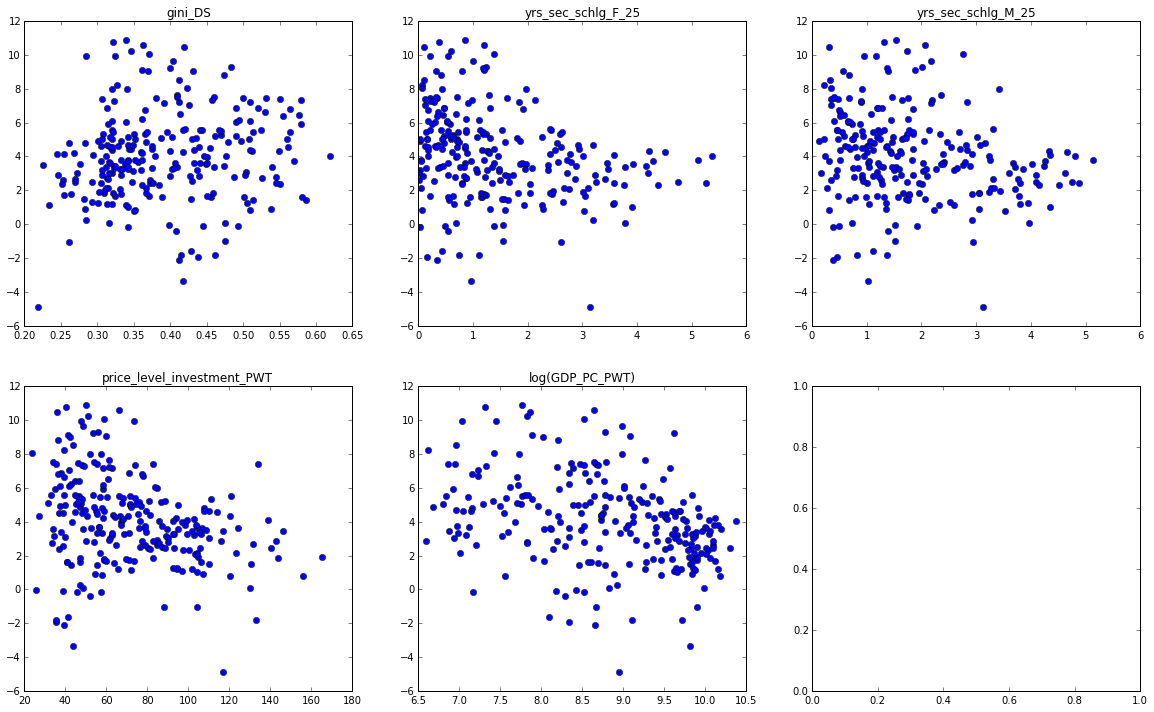

In [50]:
f, axarr = plt.subplots(2, 3, figsize=(20,12))
for n, var in enumerate(X_var.keys()):
    i,j = n/3, n%3
    axarr[i, j].plot(X_var[var], Y, 'o')
    axarr[i, j].set_title(var)